# Mapping and classifying cells using Human Lung Cell Atlas

## Setup

In [1]:
import os

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import scarches as sca
import gdown
import gzip
import shutil

 captum (see https://github.com/pytorch/captum).
INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## Download Files - Reference model, Embeddings etc.

Downloading the reference (as h5ad)

In [6]:
url = 'https://zenodo.org/record/6337966/files/HLCA_emb_and_metadata.h5ad'
output = 'HLCA_emb_and_metadata.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://zenodo.org/record/6337966/files/HLCA_emb_and_metadata.h5ad
To: /home/icb/aleksandra.topalova/scarches/data/HLCA_emb_and_metadata.h5ad
100%|██████████| 218M/218M [00:06<00:00, 33.7MB/s] 


'HLCA_emb_and_metadata.h5ad'

Downloading the reference model and unzipping

In [7]:
url = 'https://zenodo.org/record/6337966/files/HLCA_reference_model.zip'
output = 'HLCA_reference_model.zip'
gdown.download(url, output, quiet=False)
shutil.unpack_archive('HLCA_reference_model.zip')
os.remove(output)

Downloading...
From: https://zenodo.org/record/6337966/files/HLCA_reference_model.zip
To: /home/icb/aleksandra.topalova/scarches/data/HLCA_reference_model.zip
100%|██████████| 5.32M/5.32M [00:00<00:00, 55.5MB/s]


## Download query data

In [8]:
query_data_url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5230027&format=file&file=GSM5230027%5F04%2DP103142%2DS149%2DR01%5Fraw%5Ffeature%5Fbc%5Fmatrix%2Eh5%2Egz"
query_metadata_url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE171668&format=file&file=GSE171668%5Flung%5Fmetadata%2Ecsv%2Egz"

In [9]:
output = 'query.h5.gz'
gdown.download(query_data_url, output, quiet=False)
with gzip.open('query.h5.gz', 'rb') as f_in:
    with open('query.h5', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
os.remove("query.h5.gz")

Downloading...
From: https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5230027&format=file&file=GSM5230027%5F04%2DP103142%2DS149%2DR01%5Fraw%5Ffeature%5Fbc%5Fmatrix%2Eh5%2Egz
To: /home/icb/aleksandra.topalova/scarches/data/query.h5.gz
100%|██████████| 27.4M/27.4M [00:01<00:00, 16.4MB/s]


In [10]:
output = 'query_obs.csv.gz'
gdown.download(query_metadata_url, output, quiet=False)

Downloading...
From: https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE171668&format=file&file=GSE171668%5Flung%5Fmetadata%2Ecsv%2Egz
To: /home/icb/aleksandra.topalova/scarches/data/query_obs.csv.gz
100%|██████████| 1.95M/1.95M [00:00<00:00, 2.94MB/s]


'query_obs.csv.gz'

## Preprocessing

In [11]:
query_data_full = sc.read_10x_h5("query.h5")
    # clean up .var.index (gene names)
query_data_full.var['gene_names'] = query_data_full.var.index
query_data_full.var.index = [idx.split("___")[-1] for idx in query_data_full.var.gene_ids]
    # clean up cell barcodes:
query_data_full.obs.index = query_data_full.obs.index.str.rstrip("-1")
    # read in metadata (to select only cells of interest and remove empty drops)
query_data_meta = pd.read_csv("query_obs.csv.gz",index_col=0)
    # subset to cells from our sample
query_data_meta = query_data_meta.loc[query_data_meta.donor == "D12_4",:].copy()
    # clean up barcodes:
query_data_meta.index = [idx.split("-")[-1] for idx in query_data_meta.index]
    # subset adata to cells in metadata:
query_data_full = query_data_full[query_data_meta.index,:].copy()
    # add dataset information:
query_data_full.obs['dataset'] = 'test_dataset_delorey_regev'

In [12]:
# gene order for scArches model
reference_gene_order = pd.read_csv('HLCA_reference_model/var_names.csv')
# reference embedding, including cell/sample/subject metadata:
reference_embedding = sc.read_h5ad('HLCA_emb_and_metadata.h5ad')

In [13]:
sca.models.SCANVI.convert_legacy_save("HLCA_reference_model", "HLCA_reference_model", overwrite=True)

In [14]:
ref_model_path = 'HLCA_reference_model'
query_data = sca.models.SCANVI.prepare_query_anndata(
    adata = query_data_full,
    reference_model = ref_model_path,
    inplace=False)

INFO     File HLCA_reference_model/model.pt already downloaded                                                     
INFO     Found 99.65% reference vars in query data.                                                                


In [15]:
query_data.obs['scanvi_label'] = 'unlabeled'

## Perform surgery

In [16]:
batch_key = 'dataset'
query_batch = ['test_dataset_delorey_regev']

In [17]:
surgery_epochs = 500
early_stopping_kwargs_surgery = {
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

Surgery

In [18]:
surgery_model = sca.models.SCANVI.load_query_data(
        query_data,
        ref_model_path,
        freeze_dropout = True,
    )

INFO     File HLCA_reference_model/model.pt already downloaded                                                     


In [19]:
surgery_model._unlabeled_indices = np.arange(query_data.n_obs)
surgery_model._labeled_indices = []

In [20]:
#TODO: Check args
surgery_model.train(
     max_epochs=surgery_epochs,
    **early_stopping_kwargs_surgery
)

INFO     Training for 500 epochs.                                                                                  


INFO:pytorch_lightning.utilities.rank_zero:Multiprocessing is handled by SLURM.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO:pytorch_lightning.trainer.connectors.signal_connector:SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 500/500: 100%|██████████| 500/500 [01:42<00:00,  6.07it/s, loss=510, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [01:42<00:00,  4.88it/s, loss=510, v_num=1]


In [21]:
surgery_path = 'surgery_model'
surgery_model.save(surgery_path, overwrite=True)

### Get latent representation

In [22]:
query_data_latent = sc.AnnData(surgery_model.get_latent_representation(query_data))
query_data_latent.obs = query_data.obs.loc[query_data.obs.index,:]

# Combine embeddings

In [23]:
query_data_latent.obs['ref_or_query'] = "query"
reference_embedding.obs['ref_or_query'] = "ref"

In [24]:
combined_emb = reference_embedding.concatenate(query_data_latent, index_unique=None)

# UMAP

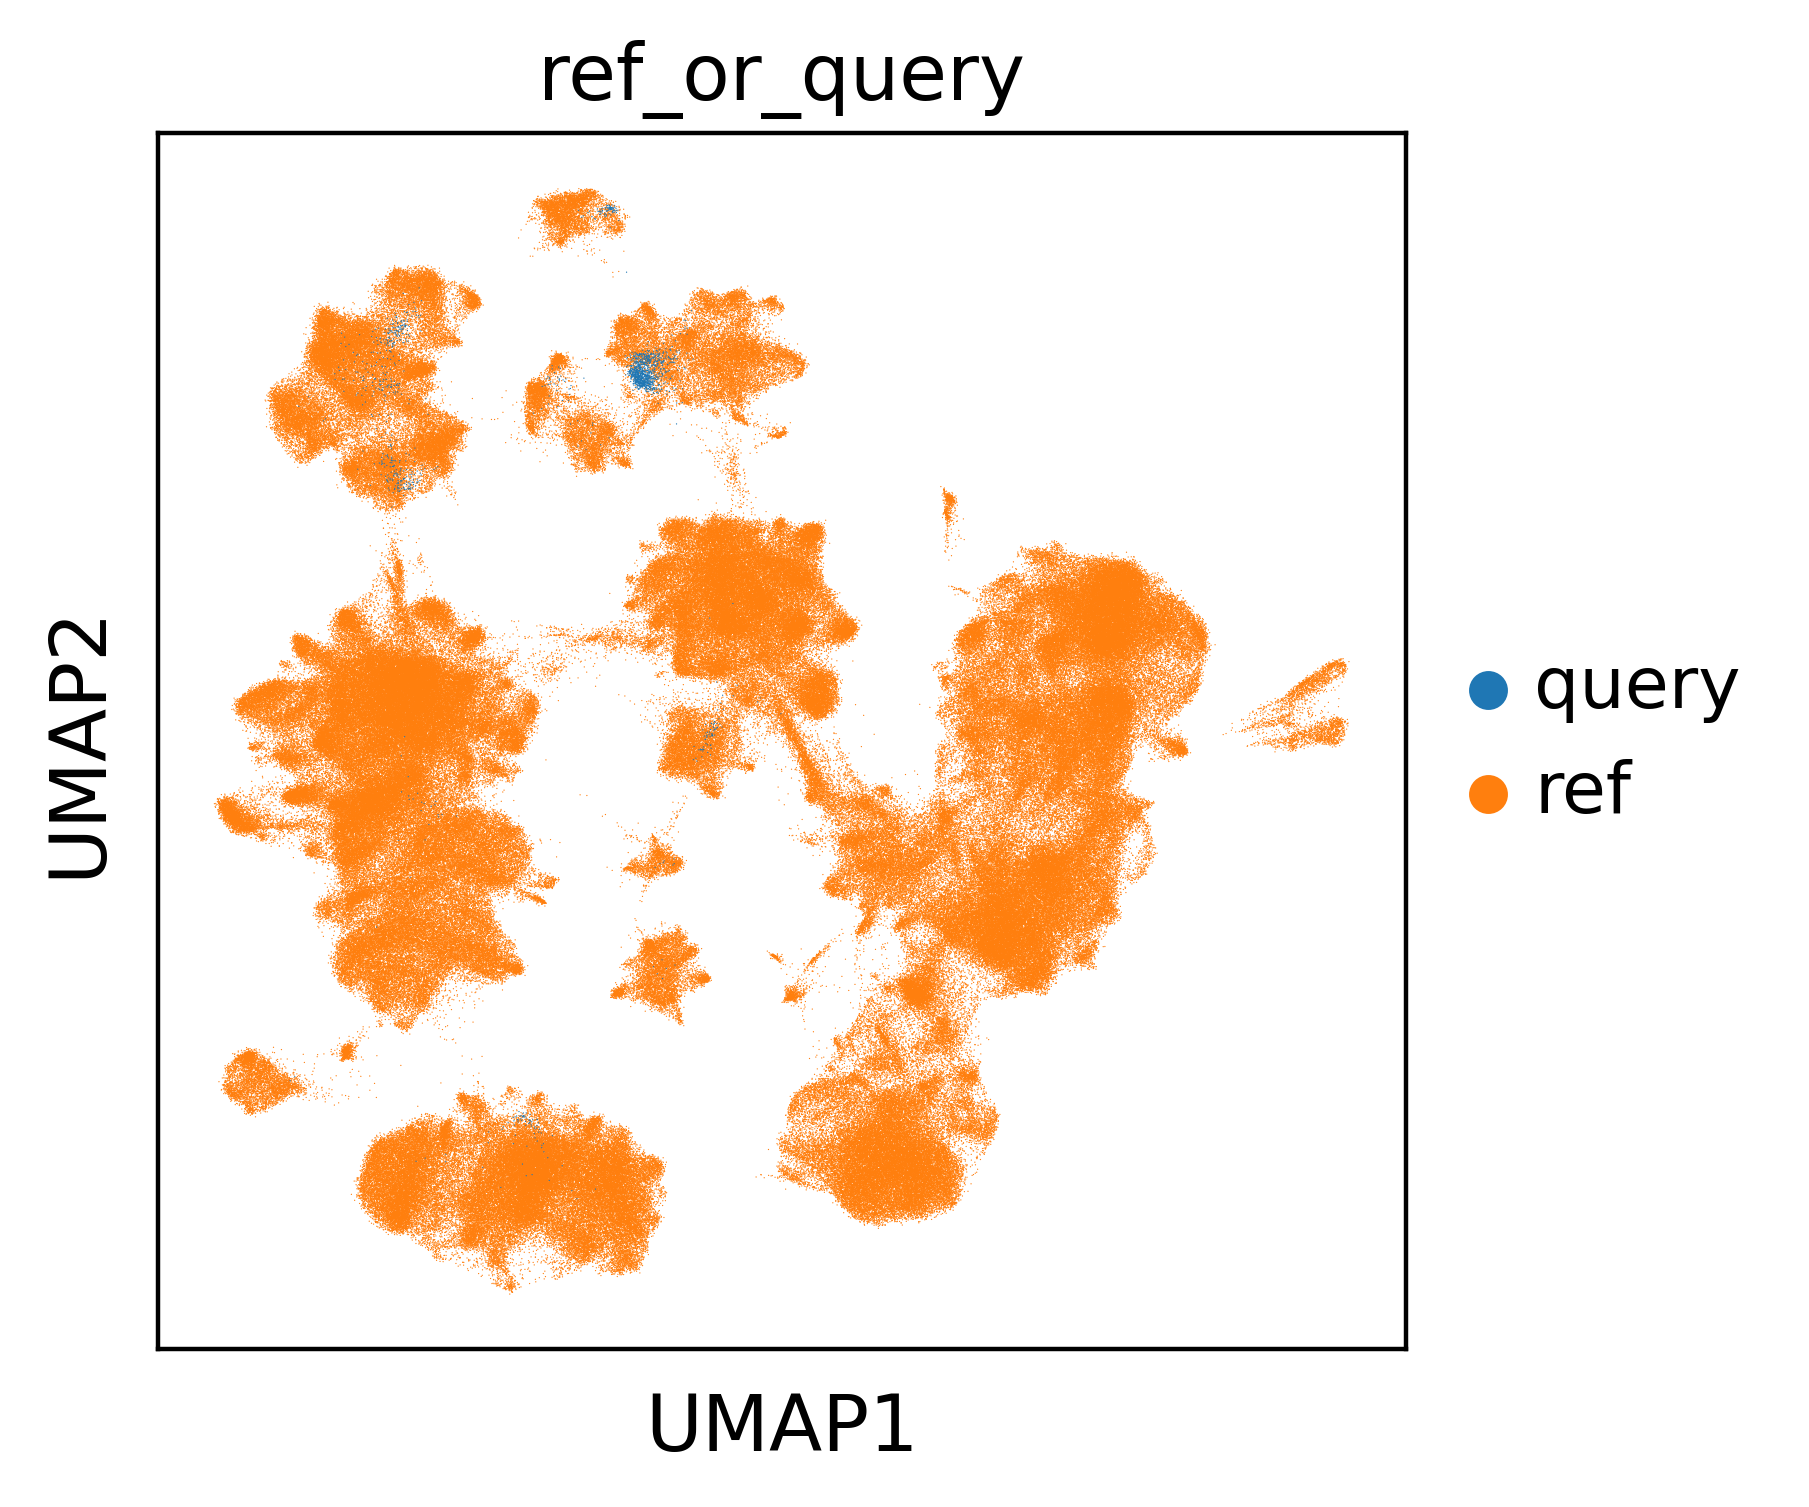

In [25]:
sc.pp.neighbors(combined_emb, n_neighbors=30)
sc.tl.umap(combined_emb)
sc.pl.umap(combined_emb, color="ref_or_query")

Saving combined embeddings (optional)

In [26]:
combined_emb.write_h5ad('../data/combined_embedding.h5ad')

# Label transfer

In [27]:
url = 'https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv'
output_celltypes = '../data/HLCA_celltypes_ordered.csv'
gdown.download(url, output_celltypes, quiet=False)


Downloading...
From: https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_celltypes_ordered.csv
To: /home/icb/aleksandra.topalova/scarches/data/HLCA_celltypes_ordered.csv
5.81kB [00:00, 4.11MB/s]                   


'../data/HLCA_celltypes_ordered.csv'

In [28]:
url = 'https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_scarches_gene_order.csv'
output_gene_order = '../data/HLCA_scarches_gene_order.csv'
gdown.download(url, output_gene_order, quiet=False)

Downloading...
From: https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/raw/main/supporting_files/HLCA_scarches_gene_order.csv
To: /home/icb/aleksandra.topalova/scarches/data/HLCA_scarches_gene_order.csv
45.1kB [00:00, 24.1MB/s]                   


'../data/HLCA_scarches_gene_order.csv'

In [29]:
cts_ordered = pd.read_csv(output_celltypes,index_col=0)    

In [30]:
knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=reference_embedding,
    train_adata_emb="X",
    n_neighbors=50,
)

Weighted KNN with n_neighbors = 50 ... 

In [31]:
labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=query_data_latent,
    query_adata_emb="X", # location of our joint embedding
    label_keys="Level",
    knn_model=knn_transformer,
    ref_adata_obs = reference_embedding.obs.join(cts_ordered, on='ann_finest_level')
    )

finished!


In [32]:
uncertainty_threshold = 0.2

In [33]:
labels.rename(columns={f"Level_{lev}":f"Level_{lev}_transfered_label_unfiltered" for lev in range(1,6)},inplace=True)
uncert.rename(columns={f"Level_{lev}":f"Level_{lev}_transfer_uncert" for lev in range(1,6)},inplace=True)

In [34]:
combined_emb.obs = combined_emb.obs.join(labels)
combined_emb.obs = combined_emb.obs.join(uncert)

In [35]:
# convert to arrays instead of categoricals, and set "nan" to NaN 
for col in combined_emb.obs.columns:
    if col.endswith("_transfer_uncert"):
        combined_emb.obs[col] = list(np.array(combined_emb.obs[col]))
    elif col.endswith("_transfered_label_unfiltered"):
        filtered_colname = col.replace("_unfiltered","")
        matching_uncert_col = col.replace("transfered_label_unfiltered","transfer_uncert")
        
        # also create a filtered version, setting cells with too high 
        # uncertainty levels to "Unknown"
        combined_emb.obs[filtered_colname] = combined_emb.obs[col]
        combined_emb.obs[filtered_colname].loc[combined_emb.obs[matching_uncert_col]>uncertainty_threshold] = "Unknown"
        # convert to categorical:
        combined_emb.obs[col] = pd.Categorical(combined_emb.obs[col])
        combined_emb.obs[filtered_colname] = pd.Categorical(combined_emb.obs[filtered_colname])
        # then replace "nan" with NaN (that makes colors better in umap)
        combined_emb.obs[col].replace("nan",np.nan,inplace=True)
        combined_emb.obs[filtered_colname].replace("nan",np.nan,inplace=True)

/tmp/ipykernel_34716/362434418.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_emb.obs[filtered_colname].loc[combined_emb.obs[matching_uncert_col]>uncertainty_threshold] = "Unknown"
/tmp/ipykernel_34716/362434418.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_emb.obs[filtered_colname].loc[combined_emb.obs[matching_uncert_col]>uncertainty_threshold] = "Unknown"
/tmp/ipykernel_34716/362434418.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [36]:
print(f"Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:")
for level in range(1,6):
    print(f"Level {level}: {np.round(sum(combined_emb.obs[f'Level_{level}_transfered_label'] =='Unknown')/query_data.n_obs*100,2)}%")

Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 0.5%
Level 2: 1.12%
Level 3: 10.64%
Level 4: 51.4%
Level 5: 51.51%


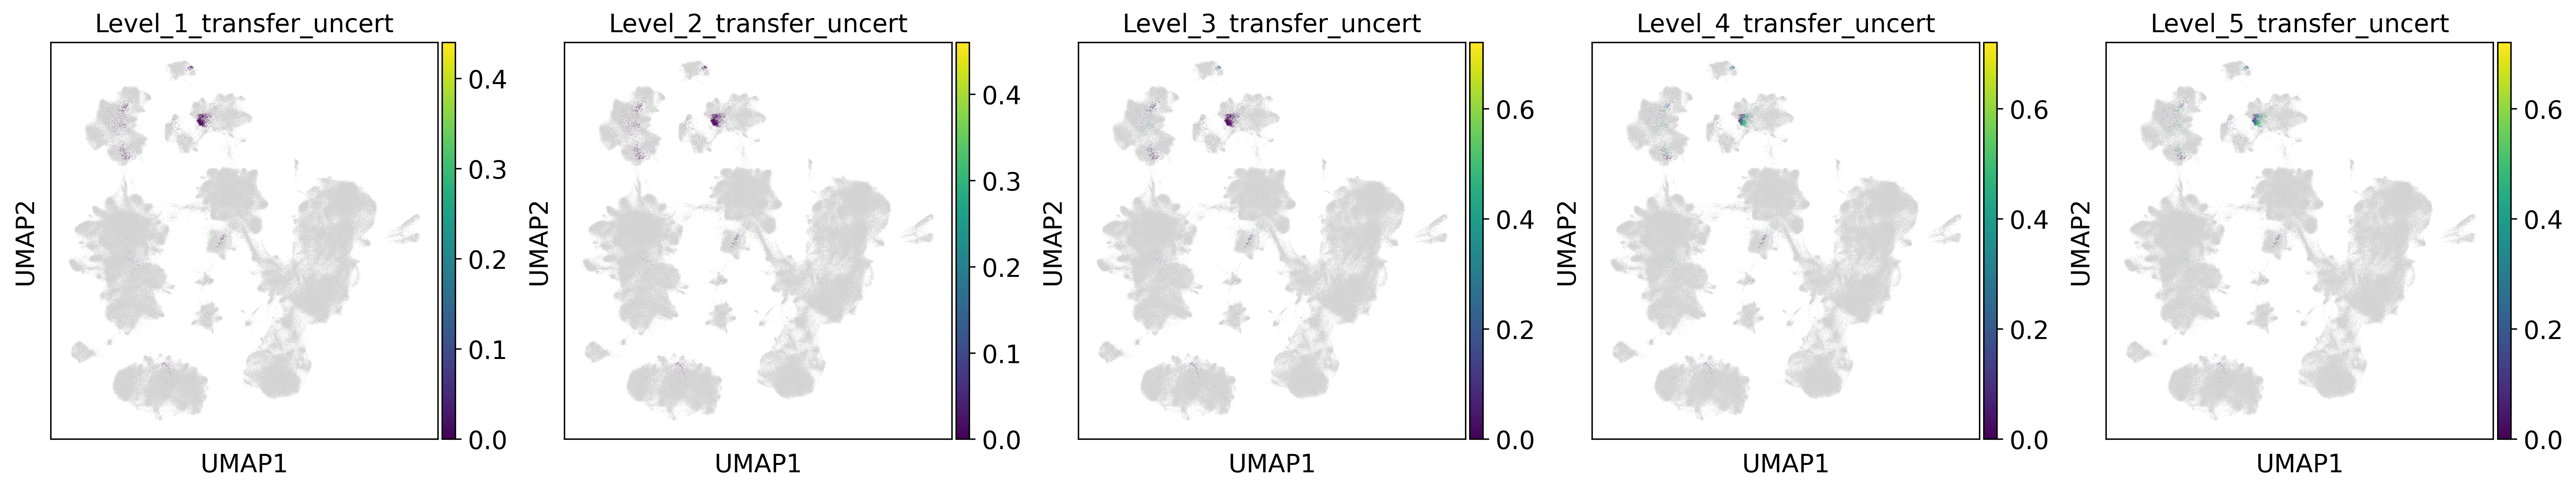

In [37]:
sc.pl.umap(
    combined_emb,
    color=[f"Level_{lev}_transfer_uncert" for lev in range(1,6)],
    ncols=5)

### UMAP Uncertainties 

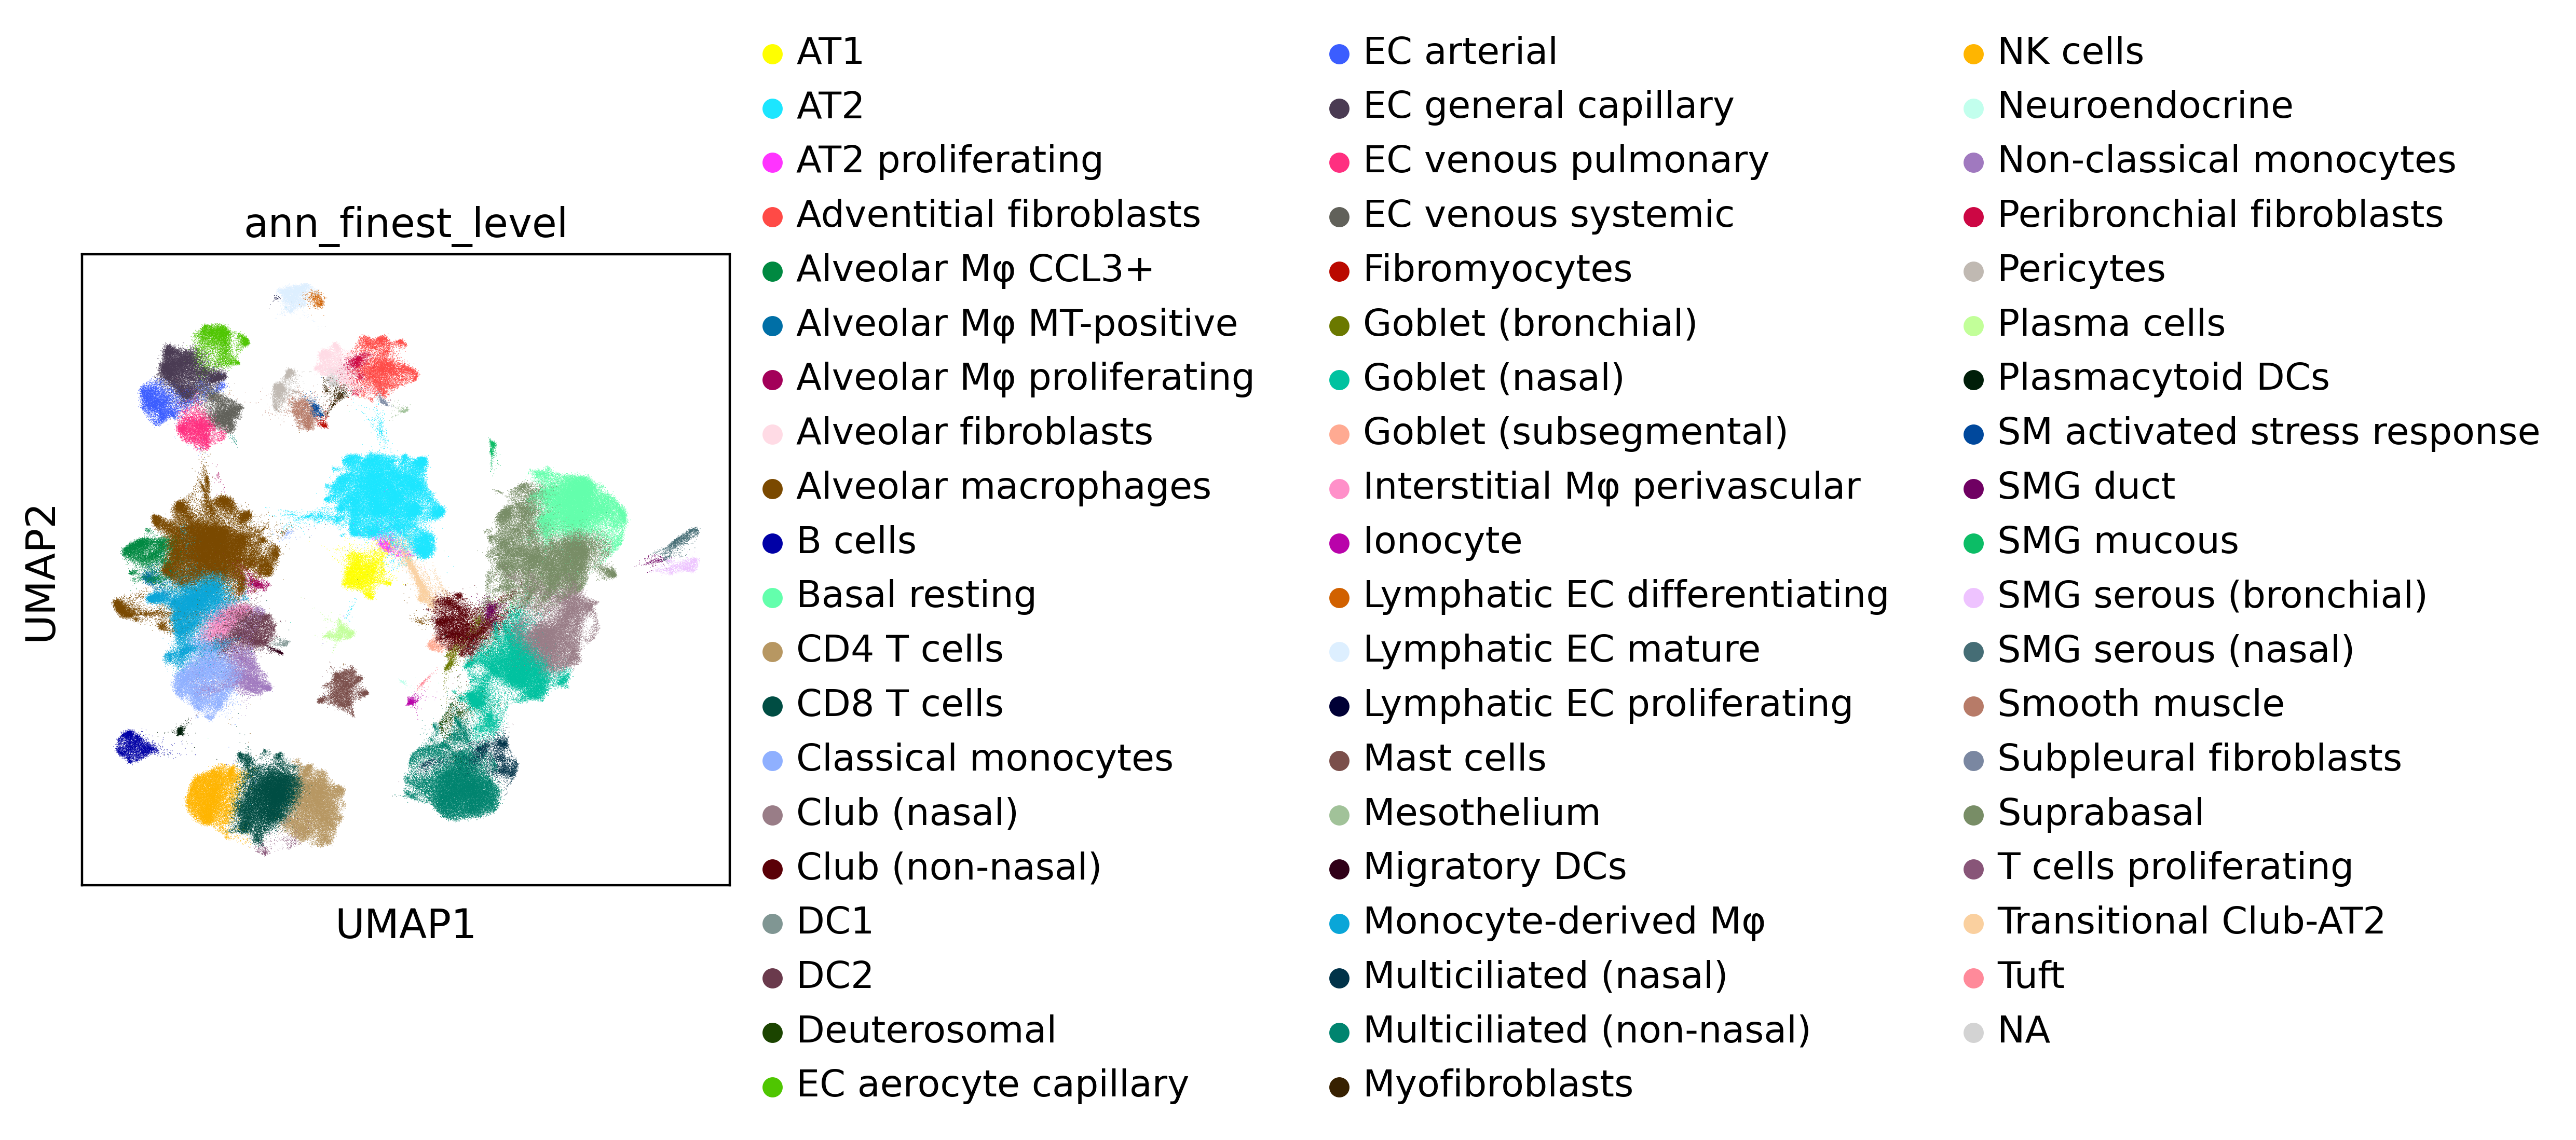

In [38]:
sc.pl.umap(combined_emb, color="ann_finest_level")